Transmission Count by Category:
Category A: 7459 times
Category B: 22898 times
Category C: 69376 times


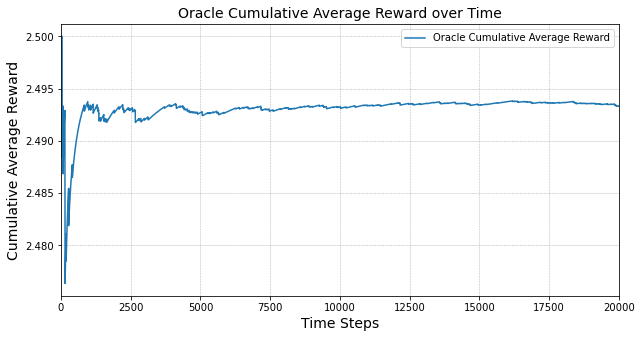

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(20000)  # Restrict to first 20000 time steps

# Parameters
reward = 0.5
M = 5  # Maximum number of nodes that can be polled
theta = 0.5  # Threshold for reward condition
penalty = -0.5  # Penalty for polling when difference is <= theta
aoii_penalty = 0.5
initial_value = 20  # Initial estimate for last polled values

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Track the number of times each category is pulled
category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}

# Initialize last polled values for each mote
last_polled_values = {col: initial_value for col in columns}

# Function to extract numeric node ID from column names dynamically
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Oracle policy simulation function
def run_oracle_simulation(M):
    last_update_times = {col: 0 for col in columns}  # Initialize last update times
    cumulative_reward = 0  # Total cumulative reward
    cumulative_rewards = []  # Store cumulative average reward over time
    valuable_sensor_data = []

    for t in range(len(pivot_df)):  # Loop over each time step
        current_time_step = t
        diffs = {}

        # Calculate rewards for each mote
        for mote in columns:
            current_value = pivot_df.loc[current_time_step, mote]
            last_value = last_polled_values[mote]

            # Reward is the difference between the current and last value
            diffs[mote] = abs(current_value - last_value)

        # Filter nodes with rewards greater than the threshold
        eligible_nodes = {mote: diff for mote, diff in diffs.items() if diff > theta}

        # Select the top M nodes among eligible nodes
        top_m_nodes = sorted(eligible_nodes, key=eligible_nodes.get, reverse=True)[:M]

        total_reward_for_round = 0

        # Process the selected nodes
        for mote in top_m_nodes:
            measured_value = pivot_df.loc[current_time_step, mote]
            last_value = last_polled_values[mote]

            # Calculate reward
            total_reward_for_round += reward  # Reward (since all polled nodes have value > theta)

            # Update last polled value and time
            last_update_times[mote] = current_time_step
            last_polled_values[mote] = measured_value

            # Extract node ID dynamically and categorize
            node_id = extract_node_id(mote)
            if node_id is not None:
                if 1 <= node_id <= 10:
                    category_counts['Category A'] += 1
                elif 11 <= node_id <= 20:
                    category_counts['Category B'] += 1
                elif 21 <= node_id <= 30:
                    category_counts['Category C'] += 1

            # Store valuable sensor data
            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,
                'predicted_temperature': measured_value,  # Oracle knows the true value
                'time_elapsed': current_time_step - last_update_times[mote]
            })

        # Update cumulative reward
        cumulative_reward += total_reward_for_round
        cumulative_rewards.append(cumulative_reward / (t + 1))  # Compute cumulative average reward

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)
    return cumulative_rewards, valuable_sensor_df, category_counts

# Run the simulation for the given value of M
cumulative_rewards_oracle, valuable_sensor_df, category_pulled_counts = run_oracle_simulation(M)

# Print the number of times each category was pulled
print("Transmission Count by Category:")
for category, count in category_pulled_counts.items():
    print(f"{category}: {count} times")

# Save cumulative rewards to CSV
# Save cumulative rewards to CSV
pd.DataFrame(cumulative_rewards_oracle, columns=["cumulative_reward"]).to_csv("cumulative_rewards_oracle_final.csv", index=False)

# Save valuable sensor data to CSV
valuable_sensor_df.to_csv("valuable_sensor_data_oracle.csv", index=False)


# Plot cumulative average reward over time for Oracle
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_rewards_oracle) + 1), cumulative_rewards_oracle, label='Oracle Cumulative Average Reward')
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Cumulative Average Reward', fontsize=14)
plt.title('Oracle Cumulative Average Reward over Time', fontsize=14)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(0, len(cumulative_rewards_oracle))

# Save the plot
plt.savefig("oracle_cumulative_average_reward_final.png")

plt.show()


Transmission Count by Category:
Category A: 33340 times
Category B: 33350 times
Category C: 33310 times


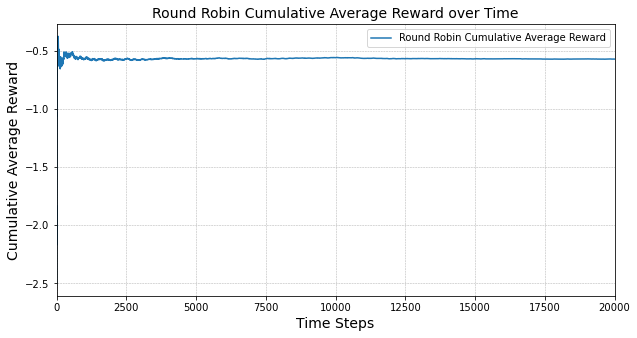

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset and preprocess
pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(20000)  # Restrict to first 20000 time steps

# Parameters
reward = 0.5
M = 5  # Maximum number of nodes that can be polled
theta = 0.5  # Threshold for significant difference
penalty = -0.5  # Penalty for insignificant difference
initial_value = 20  # Initial value for last polled
num_nodes = 30  # Total number of sensor nodes based on dataset
num_time_steps = len(pivot_df)  # Total time steps in the dataset

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]

# Track the number of times each category is pulled
category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}

# Initialize last polled values
last_polled_values_rr = {column: initial_value for column in columns}

# Function to extract numeric node ID from column names dynamically
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Round Robin simulation function with transmission count tracking
def run_simulation_round_robin(pivot_df, columns, M, theta, penalty):
    last_polled_values = {column: initial_value for column in columns}  # Last polled values
    cumulative_reward = 0  # Total cumulative reward
    cumulative_rewards = []  # Store cumulative rewards over time

    for t in range(len(pivot_df)):  # Loop over all time steps
        # Poll M nodes in cyclic order
        nodes_rr = [columns[(t + i) % num_nodes] for i in range(M)]  # Poll M nodes in cyclic order
        round_reward = 0  # Reward for the current time step

        for node_rr in nodes_rr:
            current_value = pivot_df.loc[t, node_rr]  # Current value for the node
            last_value = last_polled_values[node_rr]

            # Calculate reward or penalty
            if abs(current_value - last_value) > theta:
                round_reward += reward  # Reward
            else:
                round_reward += penalty  # Penalty

            # Update the last polled value
            last_polled_values[node_rr] = current_value

            # Extract node ID dynamically and categorize
            node_id = extract_node_id(node_rr)
            if node_id is not None:
                if 1 <= node_id <= 10:
                    category_counts['Category A'] += 1
                elif 11 <= node_id <= 20:
                    category_counts['Category B'] += 1
                elif 21 <= node_id <= 30:
                    category_counts['Category C'] += 1

        # Update cumulative reward
        cumulative_reward += round_reward
        cumulative_rewards.append(cumulative_reward / (t + 1))  # Append cumulative average reward

    return cumulative_rewards, category_counts

# Run Round Robin simulation with transmission count tracking
cumulative_rewards_rr, category_pulled_counts = run_simulation_round_robin(pivot_df, columns, M, theta, penalty)

# Print the number of times each category was pulled
print("Transmission Count by Category:")
for category, count in category_pulled_counts.items():
    print(f"{category}: {count} times")

# Save cumulative rewards to CSV
pd.DataFrame(cumulative_rewards_rr, columns=["cumulative_reward"]).to_csv("cumulative_rewards_round_robin_final.csv", index=False)

# Plot cumulative average reward over time
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_rewards_rr) + 1), cumulative_rewards_rr, label='Round Robin Cumulative Average Reward')
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Cumulative Average Reward', fontsize=14)
plt.title('Round Robin Cumulative Average Reward over Time', fontsize=14)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(0, len(cumulative_rewards_rr))

# Save the plot
plt.savefig("round_robin_cumulative_average_reward_final.png")

plt.show()


Transmission Count by Category:
Category A: 33340 times
Category B: 33330 times
Category C: 33330 times


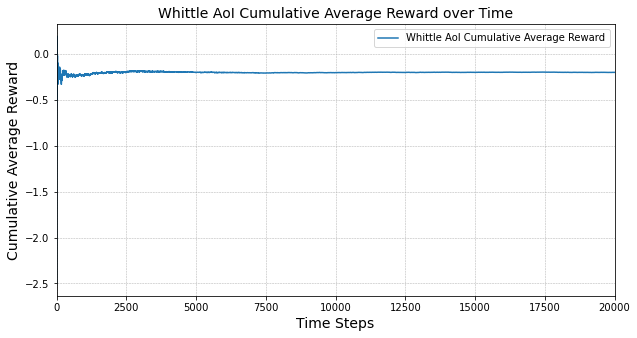

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset and preprocess
pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(20000)  # Restrict to first 20000 time steps

# Parameters
reward = 0.5
M = 5  # Number of nodes to poll
theta = 0.5  # Threshold for node transmission
penalty = -0.5  # Penalty for polling when the condition is not met
num_nodes = len([col for col in pivot_df.columns if col != "SN"])  # Total number of sensor nodes
num_time_steps = len(pivot_df)  # Total time steps in the dataset

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]

# Track the number of times each category is pulled
category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}

# Initialize last polled values
last_polled_values_whittle = {col: 20.0 for col in columns}  # Initial values

# Function to extract numeric node ID from column names dynamically
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Whittle Index-based AoI simulation function with transmission count tracking
def run_simulation_whittle_aoi(pivot_df, num_nodes, M, theta, penalty):
    """Simulate Whittle Index-based polling strategy for AoI with transmission count tracking."""
    cumulative_reward = 0
    cumulative_rewards = []
    last_update_whittle = np.zeros(num_nodes)  # Track last update times
    last_polled_values = {col: 20.0 for col in pivot_df.columns}  # Initialize last polled values

    for t in range(len(pivot_df)):  # Iterate over all time steps
        whittle_indices = {}

        # Compute Whittle indices for each node
        for node in range(num_nodes):  # Now using 0-based index
            column_name = pivot_df.columns[node]  # Get column directly
            
            delta_t_dynamic = t - last_update_whittle[node]  # Time since last update
            current_aoi = delta_t_dynamic
            future_aoi_passive = delta_t_dynamic + penalty
            future_aoi_active = 0  # Assuming perfect transmission

            q_passive = current_aoi + future_aoi_passive
            q_active = current_aoi + future_aoi_active + penalty  # No additional penalty for active action
            whittle_indices[node] = q_passive - q_active

        # Step 2: Select top M nodes
        nodes_to_poll = [node for node, index in whittle_indices.items() if index >= 0]
        if len(nodes_to_poll) > M:
            nodes_to_poll = sorted(nodes_to_poll, key=lambda node: whittle_indices[node], reverse=True)[:M]

        round_reward = 0  # Reward for the current time step

        # Step 3: Poll selected nodes
        for node in nodes_to_poll:
            column_name = pivot_df.columns[node]  # Get the column name
            
            current_value = pivot_df.loc[t, column_name]
            last_value = last_polled_values[column_name]

            # Calculate reward or penalty
            if abs(current_value - last_value) > theta:
                round_reward += reward  # Reward
            else:
                round_reward += penalty  # Penalty

            # Update last polled values
            last_polled_values[column_name] = current_value
            last_update_whittle[node] = t  # Update last update time

            # Extract node ID dynamically and categorize
            node_id = extract_node_id(column_name)
            if node_id is not None:
                if 1 <= node_id <= 10:
                    category_counts['Category A'] += 1
                elif 11 <= node_id <= 20:
                    category_counts['Category B'] += 1
                elif 21 <= node_id <= 30:
                    category_counts['Category C'] += 1

        # Update cumulative reward
        cumulative_reward += round_reward
        cumulative_rewards.append(cumulative_reward / (t + 1))  # Compute cumulative average reward

    return cumulative_rewards, category_counts

# Run the simulation with transmission count tracking
cumulative_rewards_whittle, category_pulled_counts = run_simulation_whittle_aoi(pivot_df, num_nodes, M, theta, penalty)

# Print the number of times each category was pulled
print("Transmission Count by Category:")
for category, count in category_pulled_counts.items():
    print(f"{category}: {count} times")

# Save cumulative rewards to CSV
pd.DataFrame(cumulative_rewards_whittle, columns=["cumulative_reward"]).to_csv("cumulative_rewards_whittle_aoi_final.csv", index=False)

# Plot cumulative average reward over time
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_rewards_whittle) + 1), cumulative_rewards_whittle, label='Whittle AoI Cumulative Average Reward')
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Cumulative Average Reward', fontsize=14)
plt.title('Whittle AoI Cumulative Average Reward over Time', fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.xlim(0, len(cumulative_rewards_whittle))

# Save the plot
plt.savefig("whittle_aoi_cumulative_average_reward_final.png")
plt.show()


Transmission Count by Category:
Category A: 22245 times
Category B: 26397 times
Category C: 43643 times


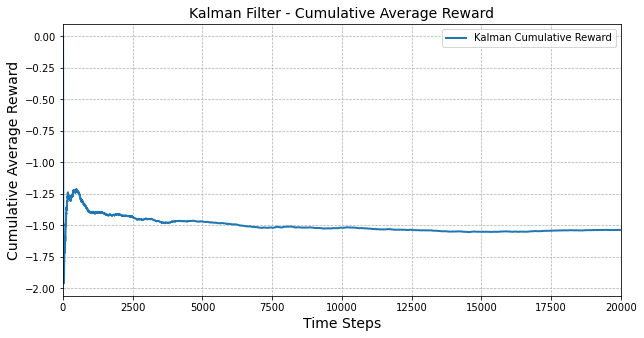

Final Cumulative Average Reward: -1.5351


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load dataset and preprocess
pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(20000)  # Restrict to first 20000 time steps

# Parameters
reward = 0.5
M = 5  # Number of nodes to poll at each time step
theta = 0.5  # Threshold for node transmission
penalty = -0.5  # Penalty when the condition is not met
num_nodes = 30  # Total number of nodes in the dataset

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]

# Track the number of times each category is polled
category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}

# Initialize state vectors and covariance matrices
x_hat_node = {col: np.array([20.0, 0.1]) for col in columns}
P_node = {col: np.eye(2) for col in columns}
x_hat_sink = {col: np.array([20.0, 0.1]) for col in columns}

# Track last update times
last_update_times = {col: 0 for col in columns}

# Kalman filter matrices
A_node = np.array([[1, 1],  # State transition matrix
                   [0, 1]])
Q_node = np.array([[0.01, 0],  # Process noise covariance
                   [0, 0.01]])
H_node = np.array([[1, 0]])  # Observation matrix
R = np.array([[0.1]])  # Measurement noise covariance

# Function to extract numeric node ID from column names dynamically
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Kalman filter function for nodes
def kalman_node(measured_value, x_hat, P):
    xp = A_node @ x_hat
    Pp = A_node @ P @ A_node.T + Q_node
    K = Pp @ H_node.T @ np.linalg.inv(H_node @ Pp @ H_node.T + R)
    x_hat = xp + K @ (measured_value - H_node @ xp)
    P = Pp - K @ H_node @ Pp
    return x_hat, P

# Predict node state from sink
def predict_node_state_from_sink(x_hat, delta_t_dynamic):
    predicted_value = x_hat[0] + x_hat[1] * delta_t_dynamic
    return np.array([predicted_value, x_hat[1]])

# Polling function with transmission count tracking
def poll_nodes(pivot_df, current_time, x_hat_node, x_hat_sink, P_node, M, cumulative_reward):
    exceedance_values = {}

    # Step 1: Predict sink values and check if threshold is exceeded
    for column_name in columns:
        last_update_time = last_update_times[column_name]
        delta_t_dynamic = current_time + 1 - last_update_time

        predicted_value = predict_node_state_from_sink(x_hat_sink[column_name], delta_t_dynamic)[0]
        if abs(predicted_value - x_hat_sink[column_name][0]) > theta:
            exceedance_values[column_name] = abs(predicted_value - x_hat_sink[column_name][0])

    # Step 2: Select top M nodes
    nodes_to_poll = sorted(exceedance_values, key=exceedance_values.get, reverse=True)[:M]

    # Step 3: Poll selected nodes
    for column_name in nodes_to_poll:
        measured_value = pivot_df.loc[current_time, column_name]

        # Node Kalman filtering
        x_hat_node[column_name], P_node[column_name] = kalman_node(measured_value, x_hat_node[column_name], P_node[column_name])
        x_hat_sink[column_name] = x_hat_node[column_name]  # Update sink state

        last_update_times[column_name] = current_time

        # Step 4: Compute reward
        if abs(measured_value - x_hat_sink[column_name][0]) > theta:
            cumulative_reward += reward  # Reward
        else:
            cumulative_reward += penalty  # Penalty

        # Extract node ID dynamically and categorize
        node_id = extract_node_id(column_name)
        if node_id is not None:
            if 1 <= node_id <= 10:
                category_counts['Category A'] += 1
            elif 11 <= node_id <= 20:
                category_counts['Category B'] += 1
            elif 21 <= node_id <= 30:
                category_counts['Category C'] += 1

    return x_hat_node, x_hat_sink, P_node, cumulative_reward

# Initialize cumulative reward tracking
cumulative_reward = 0  # Single cumulative reward for all nodes
cumulative_rewards_over_time = []  # To track cumulative average reward over time

# Simulation settings
num_steps = len(pivot_df)

# Run the simulation
for t in range(num_steps):
    x_hat_node, x_hat_sink, P_node, cumulative_reward = poll_nodes(
        pivot_df, t, x_hat_node, x_hat_sink, P_node, M, cumulative_reward
    )
    
    # Compute cumulative average reward
    avg_reward = cumulative_reward / (t + 1)
    cumulative_rewards_over_time.append(avg_reward)

# Print the number of times each category was pulled
print("Transmission Count by Category:")
for category, count in category_counts.items():
    print(f"{category}: {count} times")

# Save cumulative rewards to CSV
pd.DataFrame(cumulative_rewards_over_time, columns=["cumulative_reward"]).to_csv("cumulative_rewards_kalman_final.csv", index=False)

# Plot cumulative average reward
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_rewards_over_time) + 1), cumulative_rewards_over_time, label='Kalman Cumulative Reward', linewidth=2)
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Cumulative Average Reward", fontsize=14)
plt.title("Kalman Filter - Cumulative Average Reward", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.xlim(0, len(cumulative_rewards_over_time))

# Save the plot
plt.savefig("kalman_cumulative_average_reward_final.png")
plt.show()

# Print final cumulative reward statistics
print(f"Final Cumulative Average Reward: {cumulative_rewards_over_time[-1]:.4f}")


Transmission Count by Category:
Category A: 1791 times
Category B: 4438 times
Category C: 17203 times


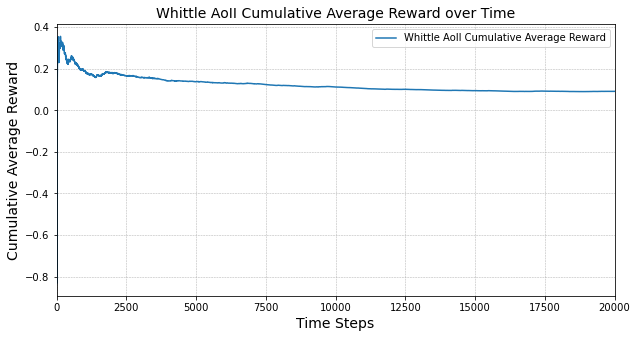

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset and preprocess
pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(20000)  # Restrict to first 20000 time steps

# Parameters
reward = 0.5
M = 5  # Maximum number of nodes that can be polled
theta = 0.5  # Threshold for reward condition
penalty = -0.5  # Penalty for polling when difference is <= theta
aoii_penalty = 0.5
initial_value = 20  # Initial estimate for last polled values

# Set parameters
beta_1 = 0.99  # dEWMA parameter for state value
beta_2 = 0.99  # dEWMA parameter for rate of change

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Track the number of times each category is pulled
category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}

# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    return abs((current_time - last_received_time) * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# Helper function to calculate reward
def calculate_reward(measured_value, last_state_value, theta, penalty):
    if abs(measured_value - last_state_value) > theta:
        return reward  # Reward
    return penalty  # Penalty

# Function to extract numeric node ID from column names dynamically, ensuring valid extraction
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Main function to simulate Whittle AoII with rewards and track transmission counts
def run_simulation_whittle_aoii(pivot_df, columns, M, theta, penalty, aoii_penalty):
    cumulative_reward = 0  # Track total cumulative reward
    cumulative_rewards = []  # Store cumulative average reward over time
    last_update_times = {col: 0 for col in columns}  # Last update time for each node
    state_node = {col: np.array([20.0, 0.1]) for col in columns}  # Node states

    for t in range(len(pivot_df)):
        # Step 1: Compute Whittle indices for each node based on AoII
        whittle_indices = {}
        for col in columns:
            last_state_value, last_rate_of_change = state_node[col]
            measured_value = pivot_df.loc[t, col]

            # Correct AoII calculation at the sink using rate of change
            current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
            future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)
            future_aoii_active = 0  # AoII resets to 0 if polled

            # Whittle index calculations
            q_passive = current_aoii + future_aoii_passive
            q_active = current_aoii + future_aoii_active + aoii_penalty
            whittle_indices[col] = q_passive - q_active

        # Step 2: Select top M nodes to poll based on Whittle indices
        nodes_to_poll = [col for col in whittle_indices if whittle_indices[col] >= 0]
        if len(nodes_to_poll) > M:
            nodes_to_poll = sorted(nodes_to_poll, key=whittle_indices.get, reverse=True)[:M]

        # Step 3: Poll selected nodes and calculate rewards
        for col in nodes_to_poll:
            measured_value = pivot_df.loc[t, col]
            last_state_value, last_rate_of_change = state_node[col]

            # Calculate reward after polling
            reward = calculate_reward(measured_value, last_state_value, theta, penalty)
            cumulative_reward += reward  # Update cumulative reward

            delta_t_dynamic = t - last_update_times[col]  # Time since last update

            # Update node state and last update time
            state_node[col] = update_node_state_dewma(
                measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, beta_1=beta_1, beta_2=beta_2
            )
            last_update_times[col] = t

            # Extract node ID dynamically and categorize
            node_id = extract_node_id(col)
            if node_id is not None:
                if 1 <= node_id <= 10:
                    category_counts['Category A'] += 1
                elif 11 <= node_id <= 20:
                    category_counts['Category B'] += 1
                elif 21 <= node_id <= 30:
                    category_counts['Category C'] += 1

        # Step 4: Calculate cumulative average reward
        cumulative_rewards.append(cumulative_reward / (t + 1))

    return cumulative_rewards, category_counts

# Run the simulation
cumulative_rewards_whittle, category_pulled_counts = run_simulation_whittle_aoii(
    pivot_df, columns, M, theta, penalty, aoii_penalty
)

# Print the number of times each category was pulled
print("Transmission Count by Category:")
for category, count in category_pulled_counts.items():
    print(f"{category}: {count} times")

# Save cumulative rewards to CSV
pd.DataFrame(cumulative_rewards_whittle, columns=["cumulative_reward"]).to_csv(
    "cumulative_rewards_whittle_aoii_final.csv", index=False
)

# Plot cumulative average reward over time
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_rewards_whittle) + 1), cumulative_rewards_whittle, label='Whittle AoII Cumulative Average Reward')
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Cumulative Average Reward', fontsize=14)
plt.title('Whittle AoII Cumulative Average Reward over Time', fontsize=14)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(0, len(cumulative_rewards_whittle))

# Save the plot
plt.savefig("whittle_aoii_cumulative_average_reward_final.png")

plt.show()


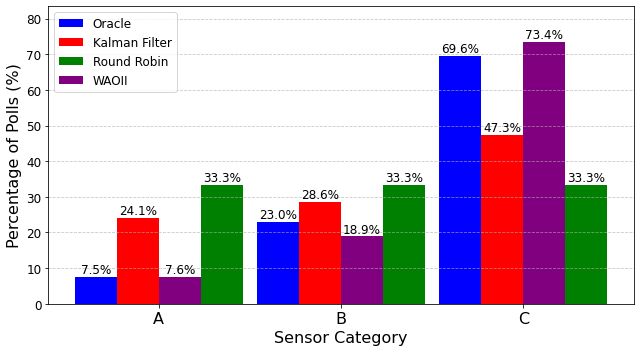

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Transmission counts
oracle_counts = [7459, 22898, 69376]
kalman_counts = [22245, 26397, 43643]
waoii_counts = [1791, 4438, 17203]

# WAOII and Round Robin are evenly distributed (33.3% each category)
waoi_round_robin_counts = [1/3, 1/3, 1/3]

# Compute total counts for each method
total_oracle = sum(oracle_counts)
total_kalman = sum(kalman_counts)
total_waoii = sum(waoii_counts)

# Convert to percentages
oracle_percentages = [count / total_oracle * 100 for count in oracle_counts]
kalman_percentages = [count / total_kalman * 100 for count in kalman_counts]
waoii_percentages = [count / total_waoii * 100 for count in waoii_counts]
waoi_round_robin_percentages = [value * 100 for value in waoi_round_robin_counts]

# Create figure for plot
plt.figure(figsize=(9, 5))

# Sensor categories
sensor_categories = ['A', 'B', 'C']
width = 0.23
x = np.arange(len(sensor_categories))

# Create bars
plt.bar(x - 1.5*width, oracle_percentages, width, label='Optimal', color='blue')
plt.bar(x - 0.5*width, kalman_percentages, width, label='KF', color='red')
plt.bar(x + 1.5*width, waoi_round_robin_percentages, width, label='Round Robin', color='green')
plt.bar(x + 0.5*width, waoii_percentages, width, label='WAOII', color='purple')

# Add percentage labels
for i, v in enumerate(oracle_percentages):
    plt.text(i - 1.5*width, v + 1, f"{v:.1f}%", ha='center', fontsize=12)
for i, v in enumerate(kalman_percentages):
    plt.text(i - 0.5*width, v + 1, f"{v:.1f}%", ha='center', fontsize=12)
for i, v in enumerate(waoii_percentages):
    plt.text(i + 0.5*width, v + 1, f"{v:.1f}%", ha='center', fontsize=12)
for i, v in enumerate(waoi_round_robin_percentages):
    plt.text(i + 1.5*width, v + 1, f"{v:.1f}%", ha='center', fontsize=12)

# Labels and formatting
plt.xlabel('Sensor Category', fontsize=16)
plt.ylabel('Percentage of Polls (%)', fontsize=16)
plt.xticks(x, sensor_categories, fontsize=16)
plt.yticks(np.arange(0, 101, 10), fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max([max(oracle_percentages), max(kalman_percentages), max(waoii_percentages), max(waoi_round_robin_percentages)]) + 10)

# Save and show plot
plt.tight_layout()
#plt.savefig("/mnt/data/activation_percentages.png", dpi=300, bbox_inches='tight')
plt.show()


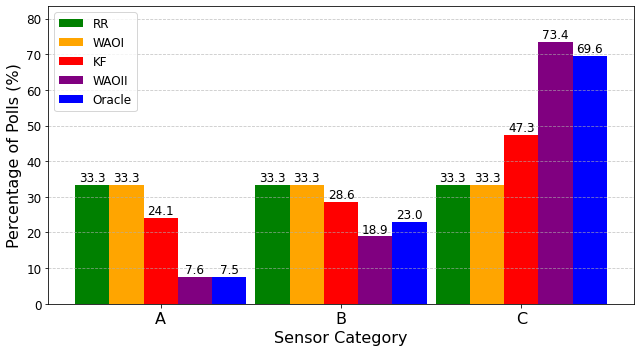

In [31]:
# Recreate the plot including WAOI with 33.3% in each category

# Transmission counts
oracle_counts = [7459, 22898, 69376]
kalman_counts = [22245, 26397, 43643]
waoii_counts = [1791, 4438, 17203]

# WAOII and Round Robin are evenly distributed (33.3% each category)
waoi_round_robin_counts = [1/3, 1/3, 1/3]
waoi_33_counts = [1/3, 1/3, 1/3]  # WAOI with 33.3% in each category

# Compute total counts for each method
total_oracle = sum(oracle_counts)
total_kalman = sum(kalman_counts)
total_waoii = sum(waoii_counts)

# Convert to percentages
oracle_percentages = [count / total_oracle * 100 for count in oracle_counts]
kalman_percentages = [count / total_kalman * 100 for count in kalman_counts]
waoii_percentages = [count / total_waoii * 100 for count in waoii_counts]
waoi_round_robin_percentages = [value * 100 for value in waoi_round_robin_counts]
waoi_33_percentages = [value * 100 for value in waoi_33_counts]

# Reorder the bars in the plot: RR, WAOI (33.3%), Kalman Filter, WAOII, Oracle

# Create figure for plot
plt.figure(figsize=(9, 5))

# Create bars in the new order
plt.bar(x - 2*width, waoi_round_robin_percentages, width, label='RR', color='green')
plt.bar(x - width, waoi_33_percentages, width, label='WAOI', color='orange')
plt.bar(x, kalman_percentages, width, label='KF', color='red')
plt.bar(x + width, waoii_percentages, width, label='WAOII', color='purple')
plt.bar(x + 2*width, oracle_percentages, width, label='Oracle', color='blue')

# Add percentage labels
for i, v in enumerate(waoi_round_robin_percentages):
    plt.text(i - 2*width, v + 1, f"{v:.1f}", ha='center', fontsize=12)
for i, v in enumerate(waoi_33_percentages):
    plt.text(i - width, v + 1, f"{v:.1f}", ha='center', fontsize=12)
for i, v in enumerate(kalman_percentages):
    plt.text(i, v + 1, f"{v:.1f}", ha='center', fontsize=12)
for i, v in enumerate(waoii_percentages):
    plt.text(i + width, v + 1, f"{v:.1f}", ha='center', fontsize=12)
for i, v in enumerate(oracle_percentages):
    plt.text(i + 2*width, v + 1, f"{v:.1f}", ha='center', fontsize=12)

# Labels and formatting
plt.xlabel('Sensor Category', fontsize=16)
plt.ylabel('Percentage of Polls (%)', fontsize=16)
plt.xticks(x, sensor_categories, fontsize=16)
plt.yticks(np.arange(0, 101, 10), fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max([max(oracle_percentages), max(kalman_percentages), max(waoii_percentages), max(waoi_round_robin_percentages), max(waoi_33_percentages)]) + 10)

# Save and show plot
plt.tight_layout()
#plt.savefig("/mnt/data/activation_percentages_reordered.png", dpi=300, bbox_inches='tight')
plt.show()
